In [1]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from scipy.stats import chi2, binned_statistic
from cosmic_calc import * 

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [12]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

#### write sf/q info and load catalog

In [13]:
def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

diagram_type = 'NUVrK'
phot_type=2 # 0=optical 1=w/nir 2=w/irac 3=full 
best_boxes_nuvrk = np.load('best_select_box_onemassbin_lepharecheck_'+diagram_type+'_.npy')
sfq_nuvrk = []

cat_output_no_nir_mass_name = graham_output_dir+'cat_out_300k_nonir_il_formass.fits'
cat = Table.read(cat_output_no_nir_mass_name)
for i in tqdm(range(len(cat))):
    gal = cat[i]
    if abs(gal['MAG_ABS_r']) < 99. and abs(gal['MAG_ABS_Ks'])< 99. and gal['MAG_ABS_NUV']< 99. and abs(gal['MAG_ABS_r'])< 99.:
        rk = gal['MAG_ABS_r'] - gal['MAG_ABS_Ks']
        nuvr = gal['MAG_ABS_NUV'] - gal['MAG_ABS_r']
        if gal['Z_ML']>0 and gal['Z_ML']<1.5:
            delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[phot_type][0],best_boxes_nuvrk[phot_type][1],best_boxes_nuvrk[phot_type][2])
            if delta_gv_nuvrk<0:
                sfq_nuvrk.append(1.)
            else:
                sfq_nuvrk.append(0.)
        else:
            sfq_nuvrk.append(-99.)
    else:
        sfq_nuvrk.append(99.)
        
sfq_col_nuvrk = Column(name='sfq_nuvrk_myrun',data=sfq_nuvrk)  # 1=sf, 0=q
if 'sfq_nuvrk_myrun' in cat.keys():
    cat.remove_column('sfq_nuvrk_myrun')
cat.add_column(sfq_col_nuvrk)
cat.write(cat_output_no_nir_mass_name.replace('.fits','_sfq_added.fits'),overwrite=True)

100%|██████████| 300000/300000 [01:58<00:00, 2538.63it/s]


In [14]:
cat = Table.read(cat_output_no_nir_mass_name.replace('.fits','_sfq_added.fits'))
arr,ind = np.unique(cat['STRING_INPUT'],return_index=True)
cat = cat[ind]

#### mass vs z
use overall catalog

(6.8, 12.6)

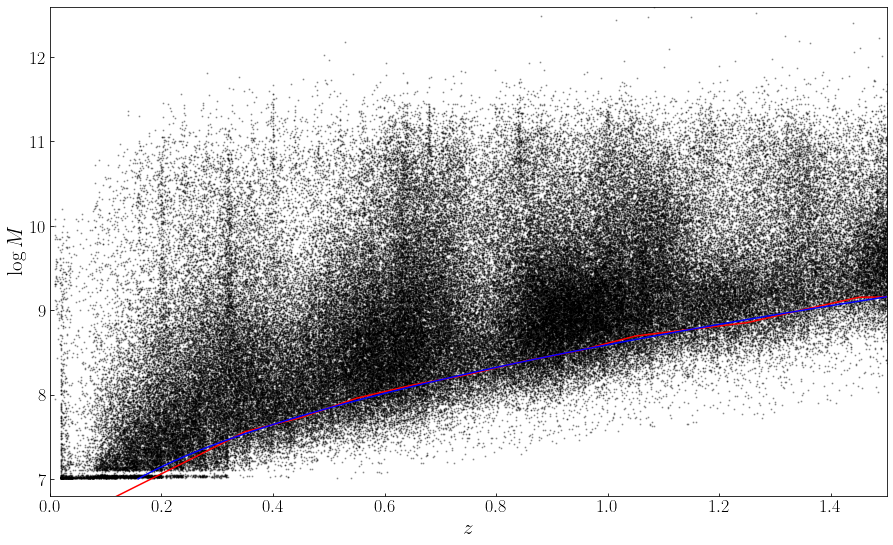

In [8]:
cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_formass.fits')

z_edges = np.linspace(0,1.6,17)
m_mins = []
for z_min in z_edges[:-1]:
    cat_z= cat[cat['Z_ML']>z_min]
    cat_z= cat_z[cat_z['Z_ML']<z_min+0.1]
    
    mass_cut20 = np.percentile(cat_z['MASS_MED_massrun'],20)
    cat_z_lowmass = cat_z[cat_z['MASS_MED_massrun']<mass_cut20]
    m_lims = cat_z_lowmass['MASS_MED_massrun'] + 0.4*(cat_z_lowmass['i']-26)
    m_min =  np.percentile(m_lims,95)
    m_mins.append(m_min)

fig, axs = plt.subplots(1, 1, figsize = (15, 9),sharex=True, sharey=True)
im = plt.scatter(cat['Z_ML'],cat['MASS_MED_massrun'],s=1,c='k',alpha=0.3)
plt.plot(z_edges[:-1]+0.05,m_mins,color='r')

# fit a 2nd order polonomial (mass as independent variable)
p = np.polyfit(m_mins,z_edges[:-1]+0.05,deg=2)
mass_plot = np.linspace(7,12.5,1000)
plt.plot(p[0]*mass_plot**2 + p[1]*mass_plot + p[2], mass_plot, color='b')

plt.xlabel('$z$',fontsize=21)
plt.ylabel('$\log M$',fontsize=21)
plt.xlim([0,1.5])
plt.ylim([6.8,12.6])

#### estimate area

In [32]:
cosmos_v9 = Table.read('clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits')
inside_j=cosmos_v9['inside_j']

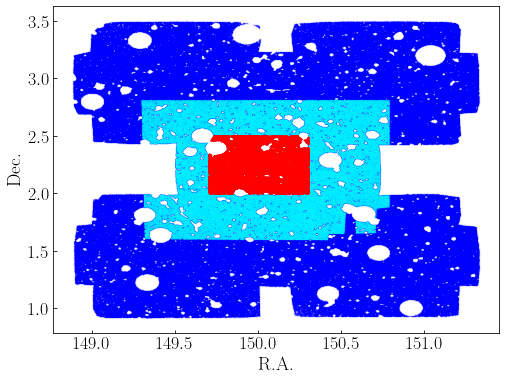

In [33]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6),sharex=True, sharey=True)
cat_output_full_name = output_dir+'cat_out_15band_il.fits'
cat_output = Table.read(cat_output_full_name)

plt.scatter(cosmos_v9['RA'],cosmos_v9 ['DEC'],s=0.1,alpha=0.1,c='b')
plt.scatter(cosmos_v9[inside_j]['RA'],cosmos_v9[inside_j]['DEC'],s=0.1,alpha=0.1,c='cyan')
plt.scatter(cat_output['RA'],cat_output['DEC'],s=1,color='r')

plt.xlabel('R.A.',fontsize=19)
plt.ylabel('Dec.',fontsize=19)
plt.savefig('/Users/lejay/Desktop/smf_paper/sky_plot.png')

In [6]:
# based on ra/dec limit
d_ra = 151.0 - 148.3
dec_1 = 0.6
dec_2 = 4.0
area = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees

# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point.fits')
# cat_random = cat_random[cat_random['RA'] > 149.7]
# cat_random = cat_random[cat_random['RA'] < 150.3]
# cat_random = cat_random[cat_random['DEC'] > 2.0]
# cat_random = cat_random[cat_random['DEC'] < 2.5]
cat_random = cat_random[cat_random['RA'] > 148.3]
cat_random = cat_random[cat_random['RA'] < 151.9]
cat_random = cat_random[cat_random['DEC'] > 0.6]
cat_random = cat_random[cat_random['DEC'] < 4.0]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area = area * len(cat_random_nomask)/len(cat_random)
print(area)

# volume
total_soid_angle = 360**2/np.pi

3.3048695671346136


#### Thibaud's Stellar Mass Functions

In [30]:
# 0.2 - 0.5 
data_q1 = np.array([8.9170, -2.7438,
9.0377, -2.8086,
9.1584, -2.9081,
9.2867, -2.9816,
9.4049, -3.0508,
9.5256, -3.1027,
9.6513, -3.0984,
9.7695, -3.0854,
9.8927, -3.0422,
10.018, -2.9773,
10.139, -2.9341,
10.262, -2.9168,
10.383, -2.8692,
10.506, -2.8692,
10.627, -2.8605,
10.755, -2.9038,
10.873, -2.9946,
10.994, -3.0897,
11.120, -3.2800,
11.243, -3.4703,
11.364, -3.7946,
11.487, -4.1665,
11.605, -4.5081,
11.731, -4.9276,
11.839, -5.5330])
data_q1 = data_q1.reshape(len(data_q1)//2,2)

# 0.5 - 0.8
data_q2 = np.array([9.6745, -3.3924,
9.7626, -3.2670,
9.8557, -3.2368,
9.9463, -3.2022,
10.049, -3.1589,
10.135, -3.1157,
10.231, -3.0984,
10.319, -3.0595,
10.412, -3.0292,
10.508, -3.0032,
10.601, -3.0335,
10.701, -3.0119,
10.789, -3.0595,
10.883, -3.1027,
10.978, -3.1762,
11.066, -3.2800,
11.167, -3.4357,
11.268, -3.5870,
11.348, -3.7859,
11.439, -4.0584,
11.537, -4.3568,
11.615, -4.5989,
11.708, -5.2995,
11.801, -5.5114,
11.924, -6.0130])
data_q2 = data_q2.reshape(len(data_q2)//2,2)

# 0.8 - 1.1
data_q3 = np.array([10.116, -3.2757,
10.290, -3.2151,
10.476, -3.0465,
10.657, -2.9730,
10.836, -3.0292,
11.020, -3.2022,
11.199, -3.5049,
11.383, -3.9892,
11.567, -4.6551,
11.746, -5.4897])
data_q3 = data_q3.reshape(len(data_q3)//2,2)

# 1.1 - 1.5
data_q4 = np.array([10.354, -4.0195,
10.437, -3.8681,
10.545, -3.7600,
10.654, -3.7514,
10.759, -3.5654,
10.857, -3.5178,
10.956, -3.4962,
11.051, -3.5697,
11.172, -3.6908,
11.263, -3.8638,
11.371, -4.2141,
11.474, -4.5600,
11.577, -5.0486,
11.673, -5.4465,
11.781, -5.9438,
11.884, -6.0951])
data_q4 = data_q4.reshape(len(data_q4)//2,2)

data_q_list = [data_q1,data_q2,data_q3,data_q4]

In [31]:
# 0.2 - 0.5 
data_sf1 = np.array([8.7888, -1.9092,
8.9070, -1.9697,
9.0427, -1.9784,
9.1584, -2.0389,
9.2816, -2.0865,
9.3973, -2.1514,
9.5331, -2.2162,
9.6513, -2.2854,
9.7921, -2.3286,
9.9053, -2.3373,
10.023, -2.4108,
10.154, -2.4368,
10.275, -2.5059,
10.406, -2.5535,
10.519, -2.6443,
10.645, -2.7395,
10.758, -2.9038,
10.891, -3.0465,
11.009, -3.3189,
11.132, -3.5611,
11.261, -3.9373,
11.386, -4.3438,
11.502, -4.9405,
11.635, -5.9568])
data_sf1 = data_sf1.reshape(len(data_sf1)//2,2)
                   
# 0.5 - 0.8
data_sf2 = np.array([9.4857, -2.2292,
9.6871, -2.2811,
9.7978, -2.3373,
9.8935, -2.3978,
10.017, -2.4497,
10.128, -2.4973,
10.226, -2.5189,
10.341, -2.5578,
10.440, -2.5838,
10.550, -2.6530,
10.661, -2.7568,
10.762, -2.8519,
10.878, -2.9686,
10.983, -3.1589,
11.079, -3.3924,
11.197, -3.6822,
11.293, -4.0195,
11.421, -4.3395,
11.524, -4.8368,
11.628, -5.3946,
11.711, -6.0346,
11.985, -6.2249])
data_sf2 = data_sf2.reshape(len(data_sf2)//2,2)


# 0.8 - 1.1
data_sf3 = np.array([9.9622, -2.4843,
10.038, -2.4541,
10.108, -2.5103,
10.194, -2.5319,
10.262, -2.5665,
10.325, -2.5838,
10.406, -2.6141,
10.489, -2.6400,
10.549, -2.6573,
10.625, -2.7135,
10.713, -2.7697,
10.786, -2.8389,
10.864, -2.9168,
10.945, -3.0162,
11.005, -3.1416,
11.081, -3.2843,
11.146, -3.4616,
11.222, -3.7038,
11.297, -3.9416,
11.380, -4.2011,
11.456, -4.5903,
11.597, -5.3470,
11.748, -6.1038])
data_sf3 = data_sf3.reshape(len(data_sf3)//2,2)

# 1.1 - 1.5
data_sf4 = np.array([10.284, -2.7827,
10.321, -2.7611,
10.359, -2.7308,
10.399, -2.7178,
10.442, -2.7827,
10.497, -2.7957,
10.568, -2.8476,
10.648, -2.8822,
10.724, -2.9211,
10.789, -2.9643,
10.870, -3.0378,
10.945, -3.1200,
11.013, -3.2151,
11.081, -3.3319,
11.159, -3.4876,
11.230, -3.6562,
11.313, -3.8941,
11.383, -4.2097,
11.451, -4.4995,
11.527, -4.8368,
11.592, -5.0400,
11.663, -5.5459,
11.731, -6.2076])
data_sf4 = data_sf4.reshape(len(data_sf4)//2,2)

data_sf_list = [data_sf1,data_sf2,data_sf3,data_sf4]

#### comoving cosmic volume
$H_0=69.6$ km/s/Mpc, $\Omega_M=0.286$

In [17]:
V2 = 2.336 # cosmic volume at z=0.2, Gpc^3
V5 = 29.127
V8 = 94.303
V11 = 194.160
V15 = 365.540

In [18]:
Va = (V5-V2)*area/total_soid_angle*10**9 # in Mpc^3
Vb = (V8-V5)*area/total_soid_angle*10**9 # in Mpc^3
Vc = (V11-V8)*area/total_soid_angle*10**9 # in Mpc^3
Vd = (V15-V11)*area/total_soid_angle*10**9 # in Mpc^3
cosmic_volumes = [Va,Vb,Vc,Vd]

In [114]:
def poisson_interval(k, a=0.3174): 
    lows = chi2.ppf(a/2, 2*k)/2
    highs = chi2.ppf(1-a/2, 2*k+2)/2 
    
    lows=np.array(lows)
    highs=np.array(highs)
    
    lows[np.isnan(lows)]=0
    return lows, highs

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle sepa

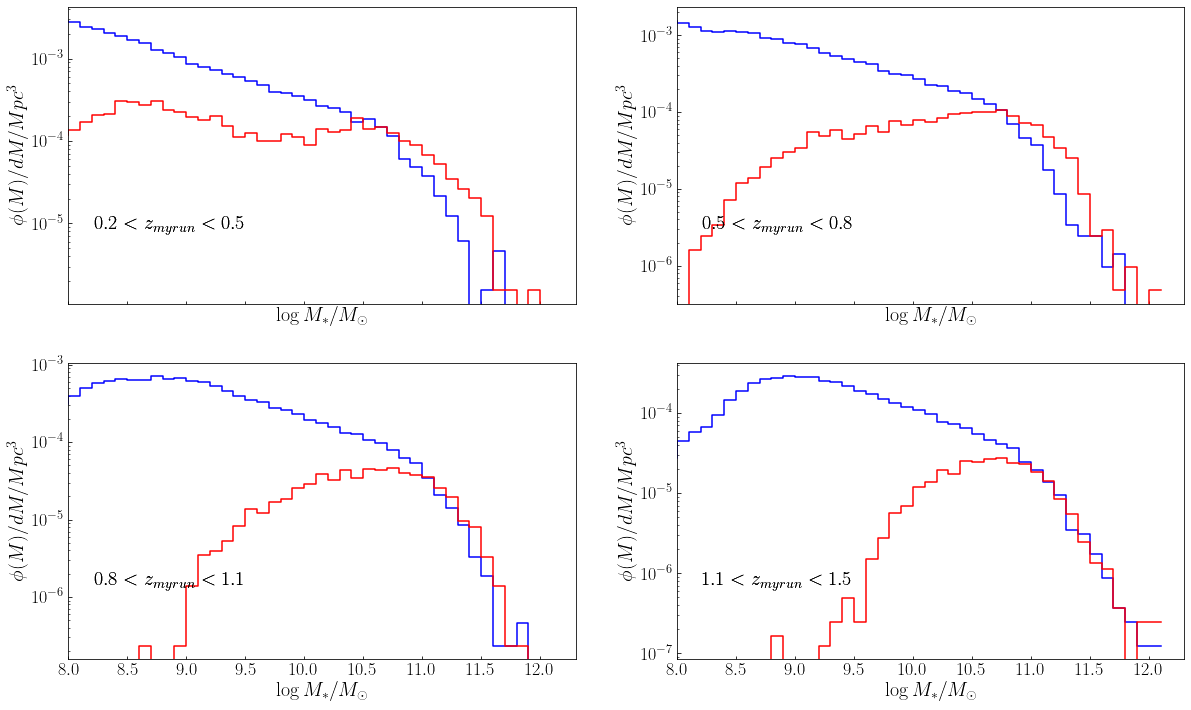

In [42]:
fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
norms = [1,1,1,1]
num_bins = 43
for i in range(len(z_mins)):
    row = i//2
    col = i%2
    cat_z = cat[cat['Z_ML']>z_mins[i]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[i]]
    cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
    cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
    
    for sfq_type in ['sf','q']:
        if sfq_type == 'sf':
            cat_z_sfqtype = cat_z[cat_z['sfq_nuvrk_myrun']>0.5]
            color='b'
        else:
            cat_z_sfqtype= cat_z[cat_z['sfq_nuvrk_myrun']<0.5]
            color='r'
    
        # 1/vmax normalization
        bins = np.linspace(8,12.2,num_bins)
        bin_size = bins[1]-bins[0]
        inv_volumes = [] # sum of inverse of volumes
        for bin_num in range(num_bins-1):
            cat_massbin = cat_z_sfqtype[np.logical_and(cat_z_sfqtype['MASS_MED_massrun']>bins[bin_num], cat_z_sfqtype['MASS_MED_massrun']<bins[bin_num+1])]
            inv_volume = 0
            for gal in cat_massbin:
                zmax = p[0]*gal['MASS_MED_massrun']**2 + p[1]*gal['MASS_MED_massrun'] + p[2]
                inv_volume += 1/ (cosmic_calc(min(zmax,z_maxs[i])) * 1e6 ) # cosmic_calc(zmax) return volume in GPc^3
            inv_volumes.append(inv_volume)            
                
        sampling_factor = 300000/1357601
        weights = 1/bin_size/sampling_factor
        n = np.array(inv_volumes)
    
        # histograms
        # weights = 1/cosmic_volumes[i]/bin_size/sampling_factor
        axs[row][col].plot(bins[:-1],n*weights,ls='steps',color=color)
        
        # mass errorbars (randomly disturb the masses)
#         mass_list = cat_z_sfqtype['MASS_MED_massrun']-0.14
#         hist_stack = []
#         for k in range(20):
#             mass_list_rand = mass_list + np.random.normal(0.2,size=len(mass_list))
#             hist,bin_edges = np.histogram(mass_list_rand,bins=bins)
#             hist_stack.append(hist)

#         mass_errbar_minus = np.mean(np.array(hist_stack),axis=0) - np.percentile(np.array(hist_stack),16,axis=0)
#         mass_errbar_plus = np.percentile(np.array(hist_stack),84,axis=0) - np.mean(np.array(hist_stack),axis=0)
    
#         # poisson errorbars
#         poisson_errbar_minus = n/weights - poisson_interval(n/weights, a=0.3174)[0]
#         poisson_errbar_plus = poisson_interval(n/weights, a=0.3174)[1] - n/weights
    
#         # total errorbars
#         errbar_minus = mass_errbar_minus + poisson_errbar_minus
#         errbar_plus = mass_errbar_plus + poisson_errbar_plus
#         axs[row][col].errorbar(bins[:-1]+np.diff(bins)/2, n, yerr=np.array([errbar_minus*weights,errbar_plus*weights]), color=color,linewidth=1,capsize=2)
    
        # reference from Moutard et al. 2016
        # axs[row][col].plot(data_q_list[i][:,0],10**data_q_list[i][:,1]*norms[i],'--r')
        # axs[row][col].plot(data_sf_list[i][:,0],10**data_sf_list[i][:,1]*norms[i],'--b')
    
        axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
        axs[row][col].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xlim([8,12.3])
        # axs[row][col].set_ylim([1e-6,4e-2])
        axs[row][col].annotate('$'+str(z_mins[i])+'<z_{myrun}<'+str(z_maxs[i])+'$',xy=([0.05,0.24]),xycoords='axes fraction',fontsize=20,color='k')
plt.savefig('/Users/lejay/Desktop/smf_paper/smf.png')
plt.show()

#### schecter function fit

In [94]:
from scipy.optimize import curve_fit
# schecter function
def schechter(m,phi,m_s,alpha_s):
    m=10**(m-7)
    return phi*(m/m_s)**(alpha_s+1)*np.exp(-((m/m_s)**2))

# fitting schecter function
def fit_schechter(xdata, ydata, ydata_err, start, end):
    popt,pcov = curve_fit(schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,2.2e+04,-1.75])
    res = ydata - schechter(xdata, *popt)
    chi2 = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2

In [ ]:
cat_z = cat[cat['Z_ML']>0.2]
cat_z = cat_z[cat_z['Z_ML']<0.5]
cat_z = cat_z[cat_z['MASK'] == 0]  # unmasked
cat_z = cat_z[cat_z['OBJ_TYPE'] == 0]  # galaxies
cat_z_sf = cat_z[cat_z['sfq_nuvrk_myrun']>0.5]
cat_z_q = cat_z[cat_z['sfq_nuvrk_myrun']<0.5]
print(len(cat_z_sf),len(cat_z_q))

[ 1.380e-03  1.017e+04 -1.493e+00]


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in power
  """
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Text(0.05, 0.24, '$0.2<z_{myrun}<0.5$')

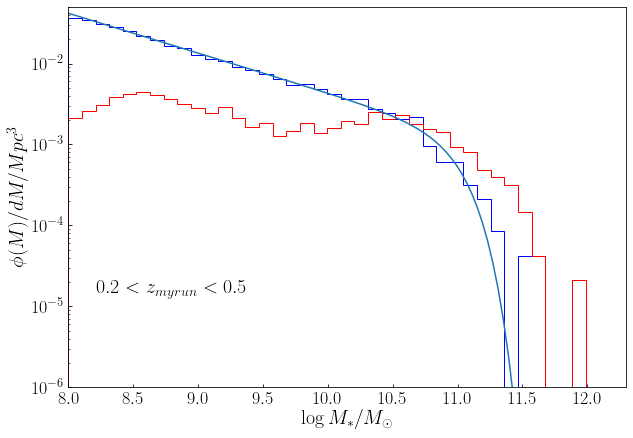

In [102]:
fig, axs = plt.subplots(1, 1, figsize = (10, 7),sharex=True)

sampling_factor = 300000/1357601
weights = 1/cosmic_volumes[0]/0.1/sampling_factor
n_sf,bins_sf,patches_sf = plt.hist(cat_z_sf['MASS_MED_massrun']-0.14, range=(8,12.2),weights=np.ones(len(cat_z_sf))*weights,bins=40,histtype='step',color='b')
n_q,bins_q,patches_q = plt.hist(cat_z_q['MASS_MED_massrun']-0.14, range=(8,12.2),weights=np.ones(len(cat_z_q))*weights,bins=40,histtype='step',color='r')

popt,pcov,chi2 = fit_schechter(bins_sf[:-1]+np.diff(bins_sf)/2, n_sf, np.sqrt(n_sf),start=5,end=-9)
print(popt)
x = np.linspace(8,12,100)
plt.plot(x,schechter(x,popt[0],popt[1],popt[2]))
    
plt.xlabel('$\log M_*/M_\odot$',fontsize=20)
plt.ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
plt.yscale('log')
plt.xlim([8,12.3])
plt.ylim([1e-6,5e-2])
plt.annotate('$0.2<z_{myrun}<0.5$',xy=([0.05,0.24]),xycoords='axes fraction',fontsize=20,color='k')

#### cosmic variance